Note: This notebook is inspired by: [GitHub Repository](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-smallest-sets.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
!pip install -U --no-cache-dir gdown --pre

np.random.seed(42)  # Set a random seed for reproducibility

In [43]:
# Download the data (if does not exist) and Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

In [44]:
# Initializations
n=2000          # number of calibration points
alpha = 0.1     # 1-alpha is the desired coverage

# Split the softmax scores into calibration and validation sets (save the shuffling)
# idx is creating a boolean array that has n elements with 1 and the remaining elements are 0, making it a binary indicator. 
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0    # list concatanation
np.random.shuffle(idx)                                  # inplace shuffle the list
cal_smx, val_smx = smx[idx, :], smx[~idx, :]
cal_labels, val_labels = labels[idx], labels[~idx]

In [45]:
# Understanding the dataset
print("\ndata['smx']: ", data['smx'])
print("\ndata['labels']: ", data["labels"])
print("\ndata['example_indexes']: ", data["example_indexes"])

print("\ndata['smx'].shape: ", data['smx'].shape)
print("\ndata['labels'].shape: ", data["labels"].shape)
print("\ndata['example_indexes'].shape: ", data["example_indexes"].shape)

print("\nmax(data['example_indexes']) ", max(data["example_indexes"]))

print("cal_smx[0]: ", cal_smx[0])               # sofmax values for all labels for the first calibration image 
print("cal_labels[0]: ", cal_labels[0])         # true label for the first calibration image

print("type(cal_smx[0]): ", type(cal_smx[0]))   # <class 'numpy.ndarray'>
print("type(cal_labels): ", type(cal_labels))   # <class 'numpy.ndarray'>


data['smx']:  [[5.55347383e-01 1.32564350e-03 5.25403069e-04 ... 1.47947849e-05
  3.24599205e-05 1.63325603e-06]
 [9.64658678e-01 1.35036071e-05 2.15132957e-07 ... 8.14401858e-07
  1.33911101e-07 6.87838053e-09]
 [3.58310223e-01 2.08239749e-06 5.65229820e-05 ... 1.50919902e-07
  1.05871993e-06 3.43750139e-09]
 ...
 [9.93386379e-07 1.08330059e-04 1.62448850e-05 ... 3.21692278e-05
  3.94053168e-05 1.20624267e-01]
 [1.09234466e-09 9.14166449e-08 5.29957367e-09 ... 2.64154121e-08
  9.08592665e-06 5.37861233e-05]
 [5.22422567e-08 3.57574663e-07 4.72474085e-07 ... 1.06125162e-06
  5.35718618e-06 1.40896440e-01]]

data['labels']:  [  0.   0.   0. ... 999. 999. 999.]

data['example_indexes']:  [16256 11680 48281   807 17359 10058 26281  7621  3767   525 40711 28459
 41200 34142   461  7983 30933 43249 23025 12534 43453 23503 12926  1365
 31127 14681 29785 25821 45741 40069 28119 38054  1761 39049 37167 33578
 47450  2418 47677 43089  8587 34076 11398 41202   561 21090 46772 14110
 24888  2738

#### Method1:
- considering softmax directly, i.e., more the score, better is the prediction. Therefore, q_level = alpha (not 1-alpha), and q_hat is used for quantile
- finite correction is not implemented in this method
- Non-adaptive Approach

In [5]:
# Step1: find the softmax values corresponding to correct label for each image
E_i_s = cal_smx[np.arange(n),cal_labels]
print("E_i_s: ", E_i_s)
print("number of images in calibration dataset: ", E_i_s.shape)                          # = (number of images in calibration dataset)

# Step2: finding the alpha quantile
q_hat = np.quantile(E_i_s, alpha)
print(f"q_hat = {q_hat}")

# Step3: finding the prediction sets
prediction_sets = (val_smx >= q_hat)

# Calculate empirical coverage - proportion of instances where the prediction sets generated by model contain the true target label.
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

E_i_s:  [3.58310223e-01 9.89989400e-01 9.99659419e-01 ... 9.95507956e-01
 3.42510611e-01 5.37861233e-05]
number of images in calibration dataset:  (2000,)
q_hat = 0.0558219775557518
The empirical coverage is: 0.8937083333333333


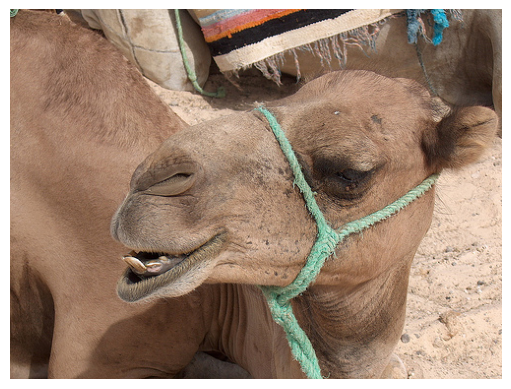

The image index is: 17731
The true label is: dromedary
The prediction set is: ['dromedary']


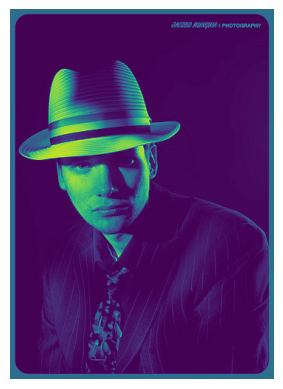

The image index is: 40414
The true label is: sombrero
The prediction set is: []


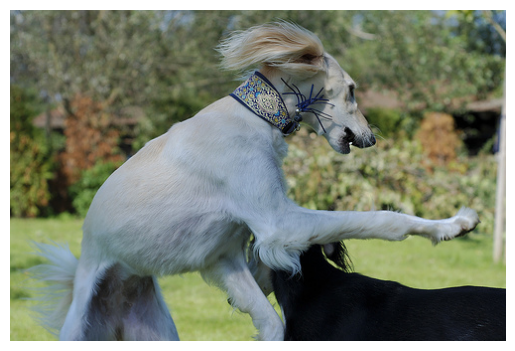

The image index is: 8837
The true label is: Saluki
The prediction set is: ['Saluki']


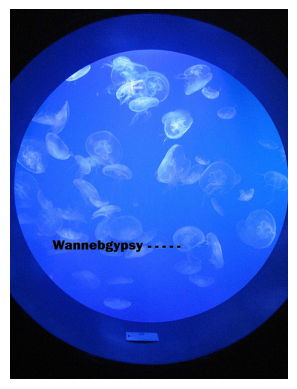

The image index is: 5375
The true label is: jellyfish
The prediction set is: ['jellyfish']


In [6]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(4):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-q_hat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The image index is: {img_index}")    
    print(f"The true label is: {label_strings[labels[img_index]]}")
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

#### Method2:
- considering scores = (1 - softmax), i.e., less the score, better is the prediction. Therefore, q_level = 1-alpha, and (1-q_hat) is used for quantile
- finite correction is implemented in this method
- Non-adaptive Approach

In [7]:
# Step1: find the scores corresponding to correct label for each image
cal_scores = 1-cal_smx[np.arange(n),cal_labels]

# Step2: finding the alpha quantile
q_level = np.ceil((n+1)*(1-alpha))/n
q_hat = np.quantile(cal_scores, q_level, interpolation='higher')
print(f"The adjusted quantile is: {q_hat}")

# Step3: finding the prediction sets
prediction_sets = (val_smx >= (1-q_hat))

# Calculate empirical coverage - proportion of instances where the prediction sets generated by model contain the true target label.
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The adjusted quantile is: 0.9451353587210178
The empirical coverage is: 0.8943541666666667


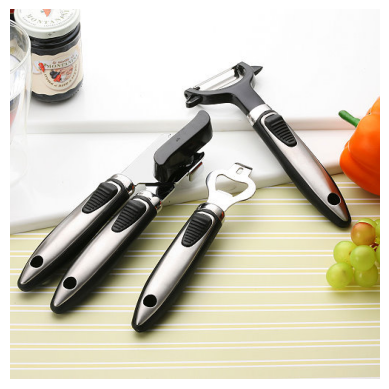

The image index is: 23679
The true label is: can opener
The prediction set is: ['can opener']


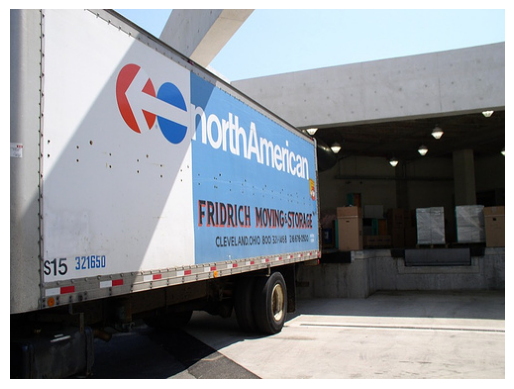

The image index is: 33785
The true label is: moving van
The prediction set is: ['moving van', 'semi-trailer truck']


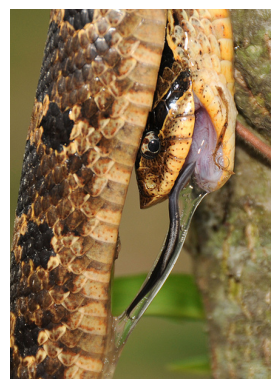

The image index is: 2736
The true label is: eastern hog-nosed snake
The prediction set is: ['eastern hog-nosed snake']


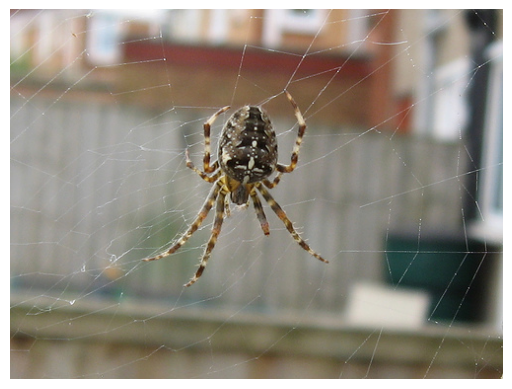

The image index is: 3715
The true label is: European garden spider
The prediction set is: ['European garden spider', 'spider web']


In [8]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(4):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-q_hat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The image index is: {img_index}")    
    print(f"The true label is: {label_strings[labels[img_index]]}")
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

#### Method3:
Adaptive Conformal

In [14]:
cal_smx, val_smx
cal_labels, val_labels
cal_smx.shape

(2000, 1000)

In [15]:
cal_labels.shape

(2000,)

In [48]:
# Step1: Calculate the sum of elements greater than labels_smx for each row

labels_smx = cal_smx[np.arange(n),cal_labels]
mask = cal_smx > labels_smx[:, np.newaxis]
E_i_s = np.sum(cal_smx * mask, axis=1)

# Step2: finding the alpha quantile
q_level_upper = np.ceil((n+1)*(1-alpha))/n
q_level_lower = 1 - q_level_upper
q_hat = np.quantile(E_i_s, q_level_lower, interpolation='higher')

In [51]:
q_level_lower

0.09950000000000003

In [21]:
cal_smx.sum(axis=1).max()

1.0000007169864245